## Emadri Coding Exercise

Time: ~10 h

### Part 1 Text embeddings and classifier

#### Data Preparation

In [11]:
import pandas as pd
import gzip
import numpy as np
import spacy

In [12]:
## read data
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

ratings = getDF('reviews_Beauty_5.json.gz')

In [13]:
ratings.rename(columns={'reviewerID': 'user_id', 
                        'asin': 'item_id', 
                        'reviewerName': 'user_name', 
                        'reviewText': 'review_text',
                        'summary': 'review_summary',
                        'overall': 'score'},
               inplace=True)

ratings.user_id = ratings.user_id.astype('category').cat.codes.values
ratings.item_id = ratings.item_id.astype('category').cat.codes.values
# Add IDs for embeddings.
ratings['user_emb_id'] = ratings['user_id']
ratings['item_emb_id'] = ratings['item_id']

In [7]:
ratings.head()

,user_id,item_id,user_name,helpful,review_text,score,review_summary,unixReviewTime,reviewTime,user_emb_id,item_emb_id
0,5584,0,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1.0,Don't waste your money,1391040000,"01 30, 2014",5584,0
1,17504,0,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3.0,OK Palette!,1397779200,"04 18, 2014",17504,0
2,14499,0,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4.0,great quality,1378425600,"09 6, 2013",14499,0
3,4157,0,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2.0,Do not work on my face,1386460800,"12 8, 2013",4157,0
4,13219,0,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3.0,It's okay.,1382140800,"10 19, 2013",13219,0


In [8]:
ratings.count()

user_id           198502
item_id           198502
user_name         197116
helpful           198502
review_text       198502
score             198502
review_summary    198502
unixReviewTime    198502
reviewTime        198502
user_emb_id       198502
item_emb_id       198502
dtype: int64

In [14]:
# save data for later use
ratings.to_csv('ratings.csv', index=False)

In [10]:
## data cleaning
nlp_en = spacy.load('en', vectors='en_glove_cc_300_1m')
review_classification = ratings[['score', 'review_summary']]
review_classification['label'] = review_classification['score']//4

labels = np.array(review_classification['label'])
reviews = list(review_classification['review_summary'])

/Users/monicayan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
print(len(labels),sum(labels)) # imbalanced data

198502 154272.0


In [ ]:
review_embs = np.vstack([nlp_en(review).vector for review in reviews])

# save for later use
np.savetxt("embedding.csv", review_embs, delimiter=",")
np.savetxt("labels.txt", labels)

In [8]:
# read embeddings
review_embs = pd.read_csv('embedding.csv', sep=',', header=None)
review_embs = review_embs.values

# read labels
labels = np.loadtxt("labels.txt")

In [41]:
# train test split with indices
from sklearn import model_selection
indices = range(len(labels))
X_train, X_test, y_train, y_test, Train, Test = model_selection.train_test_split(review_embs, labels, indices,
                                                            test_size =0.15, random_state=42)

In [90]:
# save indices to generate same train test set later on
np.savetxt("Train_index.txt", Train)
np.savetxt("Test_index.txt", Test)

In [9]:
# read index
Train = list(np.loadtxt("Train_index.txt").astype(int))
Test = list(np.loadtxt("Test_index.txt").astype(int))

In [10]:
X_train, X_test, y_train, y_test = review_embs[Train], review_embs[Test], labels[Train], labels[Test]

### Classifier Test

#### Random Forest & Logistic Regression

In [11]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pickle

In [7]:
kf = KFold(n_splits=10)

##### Random Forest

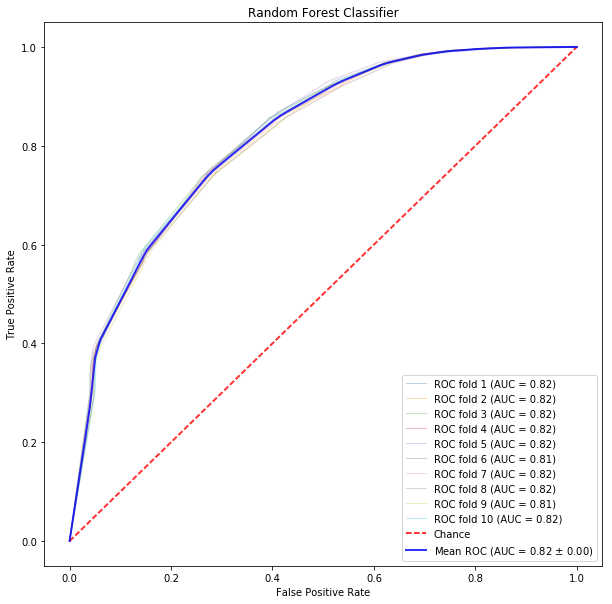

In [33]:
# initial classifier
rfc = RandomForestClassifier(n_jobs = -1)

tprs_rf = []
aucs_rf = []
mean_fpr_rf = np.linspace(0, 1, 100)

# figure setup
plt.clf()
plt.figure(figsize=(10,10))

# 10-fold cross validation
i = 1
for train_index, valid_index in kf.split(X_train):
    pred = rfc.fit(X_train[train_index], y_train[train_index]).predict_proba(X_train[valid_index])
    fpr, tpr, thresholds = roc_curve(y_train[valid_index], pred[:, 1])
    
    tprs_rf.append(interp(mean_fpr_rf, fpr, tpr))
    tprs_rf[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs_rf.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

# plot helpers
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = auc(mean_fpr_rf, mean_tpr_rf)
std_auc_rf = np.std(aucs_rf)
plt.plot(mean_fpr_rf, mean_tpr_rf, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_rf, std_auc_rf),
         lw=2, alpha=.8)

# add labels
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

##### Logistic Regression

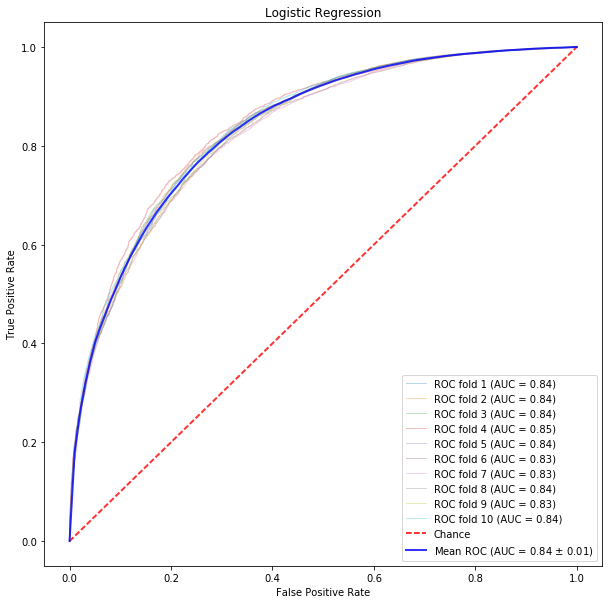

In [34]:
# initial logistic regression classifier
logr = LogisticRegression(solver='sag', n_jobs = -1)

tprs_log = []
aucs_log = []
mean_fpr_log = np.linspace(0, 1, 100)

# figure setup
plt.clf()
plt.figure(figsize=(10,10))

# 10-fold cross validation
i = 1
for train_index, valid_index in kf.split(X_train):
    pred = logr.fit(X_train[train_index], y_train[train_index]).predict_proba(X_train[valid_index])
    fpr, tpr, thresholds = roc_curve(y_train[valid_index], pred[:, 1])
    
    tprs_log.append(interp(mean_fpr_log, fpr, tpr))
    tprs_log[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs_log.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

# plot helpers
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
mean_tpr_log = np.mean(tprs_log, axis=0)
mean_tpr_log[-1] = 1.0
mean_auc_log = auc(mean_fpr_log, mean_tpr_log)
std_auc_log = np.std(aucs_log)
plt.plot(mean_fpr_log, mean_tpr_log, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_log, std_auc_log),
         lw=2, alpha=.8)

# add lables
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression')
plt.legend(loc="lower right")
plt.show()

##### Some Comments

* ** Why choose AUC as the model metrics?**   

This is a classic binary classification problem in a large dataset, and the purpose is to alert the user there comments and review should be match. When I summary the dataset, I found the data is highly imbalanced (198502 reviews in total and 154272 of them are $\geq 4.0$). Therefore, with the ROC curve and AUC metrics, I am access the `True Positive Rate` vs `False Positive Rate`, which is  $\mathbf{P} (\hat{Y} = 1 | Y=1)$ vs $\mathbf{P} (\hat{Y} = 1 | Y=0)$, which is not affect by the imbalance of the dataset.  
   
Besides, for my understanding this alert is not trying to let the stars really reflect the usr's review, so we want to let the classifier really recognize the difference between two classes. 
  
At very beginning, I thought the true purpose might be to have more 4-star reviews, so it may only has a alert when the comments are a 4-star-like description while the review is lower than 4-star. Then a recall will be a better metric.   


* ** Choose the best classifier**   

This is a large dataset, so I didn't choose the SVM method. Instead I try Random Forest and Logistic Regression. According to the metircs I choose, the Logistic Regression is the a better classifier.

In [87]:
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(logr, open(filename, 'wb'))

#### Run on the test set

In [12]:
# load model
filename = 'finalized_model.sav'
logr = pickle.load(open(filename, 'rb'))

/Users/monicayan/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.18.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


<Figure size 432x288 with 0 Axes>

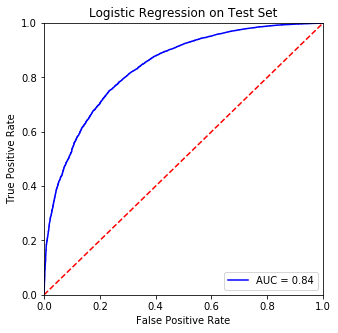

In [13]:
probs = logr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.clf()
plt.figure(figsize=(5,5))
plt.title('Logistic Regression on Test Set')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Generate word cloud

In [14]:
test_reviews = review_classification['summary'][Test]

In [15]:
predictions = logr.predict(X_test)

In [16]:
print(len(predictions), sum(predictions))

29776 25981.0


In [17]:
zeros = np.where(predictions == 0)[0]
ones = np.where(predictions == 1)[0]

In [18]:
t = review_classification['summary'][Test]
t = pd.DataFrame(t)
t.reset_index(inplace = True)

In [19]:
review_zeros = np.array(t['summary'][zeros])
review_ones = np.array(t['summary'][ones])

In [20]:
# save for later use
np.savetxt("review_0.txt", review_zeros, fmt = '%s')
np.savetxt("review_1.txt", review_ones, fmt = '%s')

In [25]:
review_00 = open("review_0.txt", "r").read() 

In [26]:
wordcloud = WordCloud().generate(review_00)

In [31]:
# save tsv file
np.savetxt("zeros_review.tsv", review_zeros, fmt = '%s')
np.savetxt("zeros_emd.tsv", review_embs[Test][zeros], delimiter='\t')

In [24]:
from wordcloud import WordCloud

(-0.5, 399.5, 199.5, -0.5)

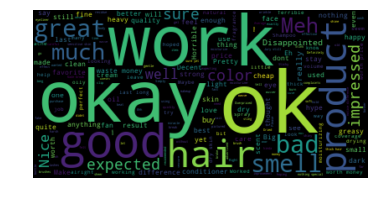

In [27]:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [29]:
review_11 = open("review_1.txt", "r").read() 
wordcloud = WordCloud().generate(review_11)

In [30]:
wordcloud1 = WordCloud().generate(review_11)

(-0.5, 399.5, 199.5, -0.5)

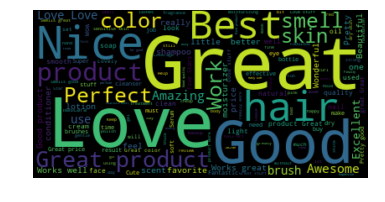

In [31]:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")

We can see from the word-cloud that the top words *in less than four-star review* are   
``ok, okay, work, good``  
while in the *above four-star review* they are  
``Great, Love, Good, Best, Nice, Prefect``   
which is quite reasonable.  

Another thing we can see in the beauty dataset is that people buy many hair products (since `hair` is a top word in both sides)